In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## TODO:

1. Data: 
    - **done** create script to combine all congresses
    - **done** create a party and chamber lists for addtional support
    - **done** create congress number list

2. Train/Val/Test split:
    -  **done** Put into a separate module
    -  **done** Add an option to select a party or chapter
    - **memory error** Split train/val/test by congress to avoid time bias
    - Play with hyperparameters:
        - word_count
        - random_splits: allocate more to training?
        - increase balance ratio?

3. EDA:
    - Targets by party: should we run gender/ethnicity on Ds only?

4. Vectorization:
    - Tune hyper parameters:
        - ngram_range: 1, 3
        - change vocabulary size
    - Add outputs:
        - **done** stop words
        - **done** lowest scoring words
        - **done** top n 5 by congress

5. Ngram model:
    - Tune hyper parameters:
        - use GridSearch?
        - activation function
        - learning rate
        - batch size
        - layers
        - units
        - dropout rate
        - any other regularization (there is significant overfit)
    - Run model:
        - for each congress
        - add one congress at a time
           - hypothesis: is accuracy improving due to more data or more diversity?
        - run only for Ds?
    - Outputs:
        - **done** how to output predicted probablity?
    - Model validation:
        - **done** build a separate function so it can be used with different models:
            - **done** input: predicted probability; actual labels; data (val or test?)
        - **done** chart distribution of the predicted probability 
        - **done** bin predicted probabilities into:
            - **done** 0:0.4, 0.4:0.6, 0.6:1?
            - **done** accuracy in each bin
            - **done** crosstab them with various demos (party, chamber, age, year)
            - **done** get 1,2,3-grams for each bin
        - **done** output examples of speeches with scores close to 1 and close to 0 that are mispredicted vs predicted correctly
        - Accuracy/loss by congress
        - Accuracy/loss as congresses added
            - save them and plot them

### Long term:

1. classificaiton models:
    - ngram vanilla NN
    - CNN
    - some other models
    - does it help to combine the results ensemble? if they make different mistakes, it should.
2. Create a topics model:
    - on raw data before classification
    - on groups based on predicted probability bings:
       - can we explain classification by topics that they bring up?
       - or is it just based on language used? here we would check 1,2,3-ngrams
3. Age:
    - aging congress: how does it affect topics that people bring up?
4. Speaker-level analysis:
    - cluster speakers (k-means?) by their average predicted scores in classification models?
        - for example, a white male that is closer to women by the way they use speech? are they liberals?

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [43]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [3]:
from w266_common import utils, vocabulary
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data

## Load the data

In [4]:
pwd

'/tf/notebooks/final-project/Classification'

In [5]:
!head -2 /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt

speech_id|speech
970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for th

In [6]:
!cat /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt | wc -l

283399


In [4]:
data_path = '/tf/notebooks/final-project/data/sample/hein-daily'

In [5]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches


In [6]:
len(all_speech_ids), len(all_speeches)

(283399, 283399)

## Create target labels

In [12]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data('/tf/notebooks/final-project/data/QA/full_descr.txt', p=0.3)
print("It took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

Random congressperson: 980036512
date 19830504
match exact
Ethnicity W
word_count 38
Party R
Female 0.0
Age_lt_med 0.0
NonWhite 0.0
speakerid 98114240.0
State IL
Age 60.0
Chamber H
char_count 200
speaker Mr. HYDE
Full Name HYDE, HENRY
Congress 98
It took 86.2 seconds to create the dictionary


In [14]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.2970220253192354

In [15]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(283399, 283399, 283399, 283399, 283399, 283399)

### Data QA

In [16]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,216667
1,0,65381
2,1,1351


Target group number of speeches by party:
D: 	 661
I: 	 0
N: 	 0
NA: 	 -216667
R: 	 690

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,216667
1,0,63946
2,1,2786


Target group number of speeches by party:
D: 	 2362
I: 	 0
N: 	 62
NA: 	 -216667
R: 	 362

 Age
Overall speech counts:


,Category,Count
0,-1,216667
1,0,43671
2,1,23061


Target group number of speeches by party:
D: 	 12263
I: 	 0
N: 	 62
NA: 	 -216667
R: 	 10736


In [17]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, gender, descr)

Speaker information
date 19820817
match exact
Ethnicity W
word_count 8
Party R
Female 1.0
Age_lt_med 1.0
NonWhite 0.0
speakerid 97109311.0
State KS
Age 50.0
Chamber S
char_count 50
speaker Mrs. KASSEBAUM
Full Name KASSEBAUM, NANCY
Congress 97

Mr. President. will the Senatori from Texas yield?


In [12]:
explore_data.random_speech(all_speeches, all_speech_ids, ethnicity, descr)

Speaker information
speakerid 97108270.0
word_count 435
State NY
Age 49.0
Full Name GARCIA, ROBERT
Congress 97
Party D
match exact
date 19820729
Female 0.0
char_count 2518
Ethnicity H
Age_lt_med 1.0
Chamber H
NonWhite 1.0
speaker Mr. GARCIA

Mr. Chairman. I believe the amendment is particularly appropriate at this moment. because we are toward the end of this bill. We have been at it for almost 40 hours. if not 40 hours. I think that there have been some discussions held here as it pertained to what exactly is in this package. At the same time. Mr. Speaker. that we are presently cutting care to the elderly and to the poor. the Federal Government is paying for the veterinary care of pets for military personnel. At the same time. Mr. Speaker. that we cut money for food stamps and lunches for schoolchildren. the taxpayers are paying for meals served in the Secretary of Defense. Casper Weinbergers private dining.room. At the same time that we cut education aid denying young men and women t

In [13]:
explore_data.random_speech(all_speeches, all_speech_ids, age, descr)

Speaker information
speakerid 97107380.0
word_count 533
State NY
Age 43.0
Full Name LUNDINE, STANLEY
Congress 97
Party D
match exact
date 19820506
Female 0.0
char_count 3341
Ethnicity W
Age_lt_med 1.0
Chamber H
NonWhite 0.0
speaker Mr. LUNDINE

Mr. Speaker. in the upcoming weeks. this legislative body will face critical decisions on a critical environmental issuereauthorization of the Clean Air Act. During the debate on this issue we will be confronted with a choice on the one hand between streamlining our efforts to preserve existing health based standards and goals for controlling emissions from stationary and mobile sources. or on the other hand. relaxing standards and timeframes for achieving and maintaining our clean air goals. The most often relied upon justification for relaxation of existing clean air standards and goals evolves around the claims by some that environmental regulation has negative impacts on productivity and economic growth. Assertions have been made by some bus

## Split into train, validate, test

### Filter on party if necessary

In [28]:
reload(load_data)
all_speeches_d, all_speech_ids_d, gender_d = load_data.filter_data(all_speeches, all_speech_ids, gender, party, 'D')
len(all_speeches_d), len(all_speech_ids_d), len(gender_d)

In [37]:
reload(explore_data)
explore_data.get_counts(gender_d)

,Category,Count
0,0,103864
1,1,2172


### Split into train/val/test

### Split by congress

In [9]:
# reload(preprocess_data)
# train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_by_congress(all_speeches, all_speech_ids, gender, descr, congress)

In [18]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 498 ones and 498 zeroes
Training speech list size: 996
Training target list size: 996
Validation split: 166 ones and 166 zeroes
Validation speech list size: 332
Validation target list size: 332
Test split: 166 ones and 166 zeroes
Test speech list size: 332
Test target list size: 332


In [19]:
sum(train_target), sum(val_target), sum(test_target)

(498, 166, 166)

In [20]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

521

In [21]:
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19820617
match exact
Ethnicity W
word_count 101
Party R
Female 1.0
Age_lt_med 0.0
NonWhite 0.0
speakerid 97106111.0
State FL
Age 55.0
Chamber S
char_count 572
speaker Mrs. HAWKINS
Full Name HAWKINS, PAULA
Congress 97

Mr. President. it is prepared as a resolution and it has become obvious this evening that in order to get the immediate attention needed that we will change it to an amendment in order to address the urgency of the situation of the captives. young Argentineans. who are on the Falkland Islands. who the British say they cannot feed. they cannot clothe. and they are becoming frostbitten. and as we sit here this evening comfortable in our seats. It is a sense of urgency there. and I prefer having a senseoftheSenate resolution but we were advised to make it an amendment.


## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [38]:
reload(explore_data)

<module 'helpers.explore_data' from '/tf/notebooks/final-project/Classification/helpers/explore_data.py'>

In [22]:
explore_data.get_num_words_per_sample(train)

212.0

In [23]:
explore_data.get_num_words_per_sample(val)

220.0

In [24]:
explore_data.get_num_words_per_sample(test)

216.5

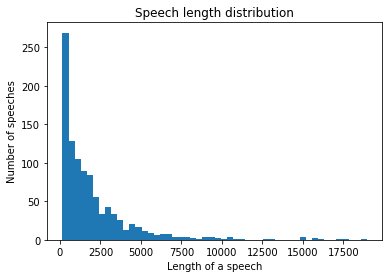

In [25]:
explore_data.plot_sample_length_distribution(train)

### Most popular unigrams (training only)

In [32]:
train_sample = random.sample(train, int(len(train)*0.2))
len(train_sample)

199

['the', 'of', 'to', 'and', 'in', 'that', 'is', 'for', 'this', 'we', 'it', 'on', 'have', 'be', 'are', 'not', 'as', 'with', 'will', 'by', 'has', 'mr', 'would', 'was', 'from', 'they', 'our', 'which', 'an', 'my', 'at', 'their', 'but', 'or', 'his', 'amendment', 'he', 'who', 'bill', 'budget', 'more', 'been', 'president', 'all', 'committee', 'there', 'people', 'time', 'do', 'if']


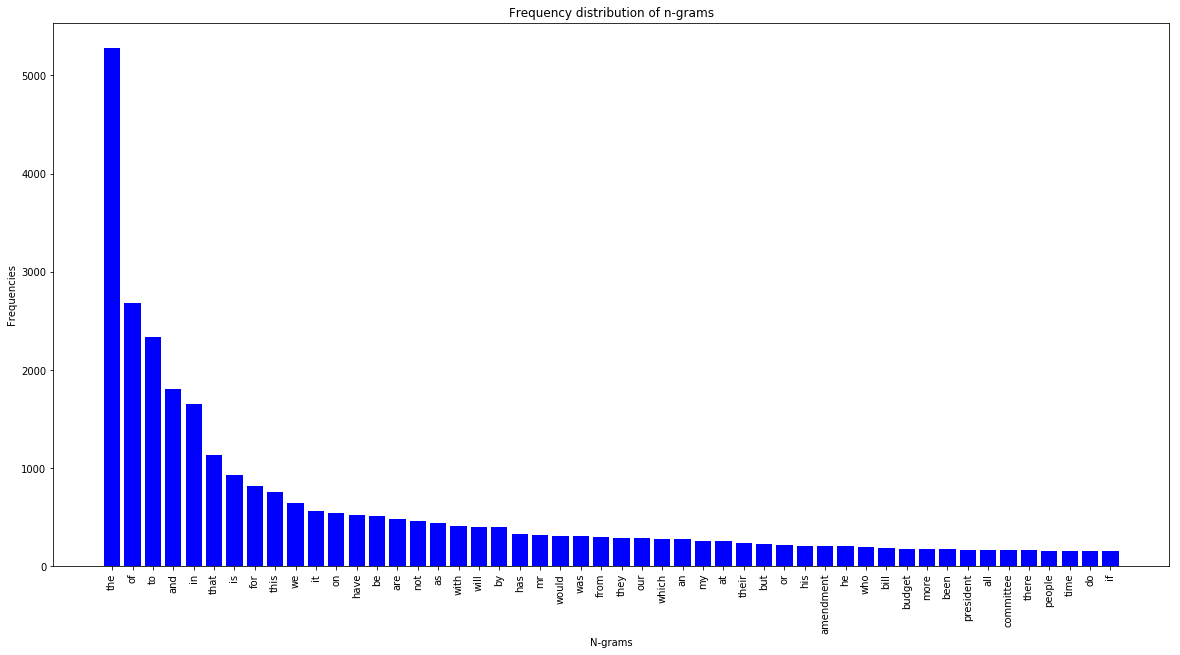

In [33]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(1,1))

### Most popular bigrams (training only)

['of the', 'in the', 'to the', 'it is', 'on the', 'that the', 'for the', 'by the', 'and the', 'of this', 'with the', 'to be', 'mr speaker', 'we are', 'will be', 'we have', 'at the', 'is the', 'mr president', 'that we', 'the gentleman', 'from the', 'the committee', 'the bill', 'of our', 'have been', 'do not', 'this is', 'has been', 'would be', 'this bill', 'there is', 'the united', 'in this', 'the budget', 'the american', 'new york', 'is not', 'the first', 'as the', 'my colleagues', 'united states', 'the federal', 'mr chairman', 'want to', 'this amendment', 'the house', 'that is', 'one of', 'the senate']


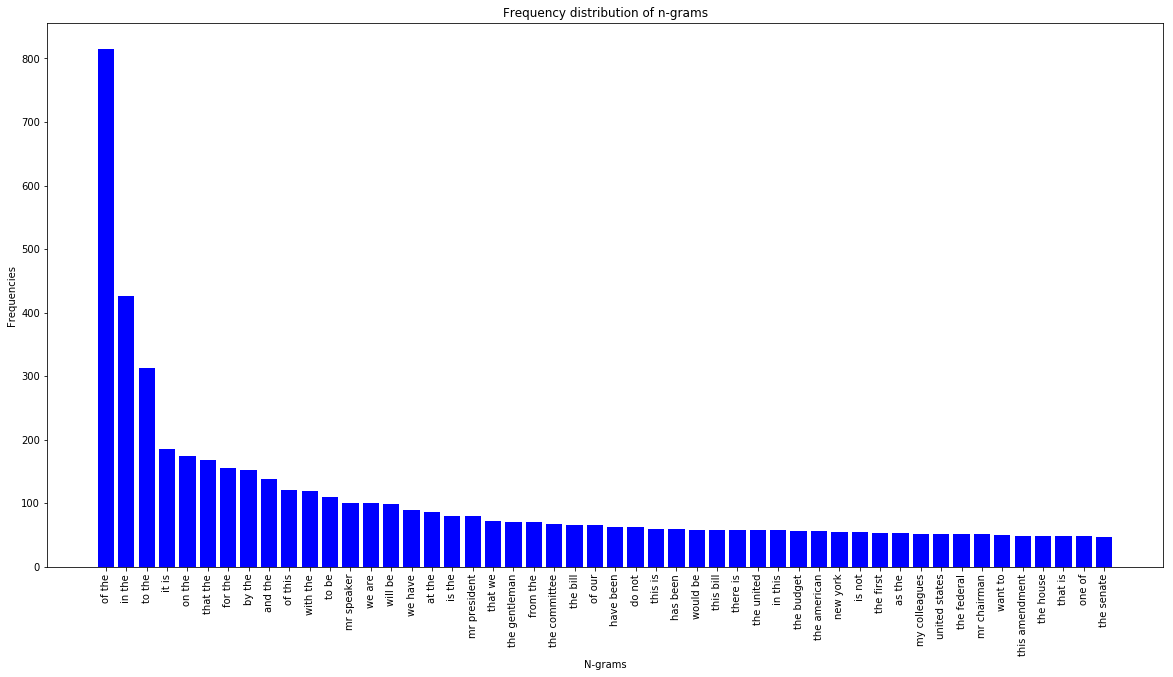

In [34]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(2,2))

### Most popular trigrams (training only)

['the united states', 'the gentleman from', 'would like to', 'one of the', 'the federal government', 'the fact that', 'chairman of the', 'the department of', 'members of the', 'member of the', 'in order to', 'the people of', 'part of the', 'out of the', 'my colleagues to', 'in new york', 'the soviet union', 'the committee on', 'of the senate', 'of the committee', 'of the bill', 'are going to', 'the american people', 'thank the gentleman', 'of the american', 'we do not', 'this is the', 'percent of the', 'of the united', 'of the house', 'new york city', 'the state of', 'the senator from', 'that we are', 'in support of', 'employment and training', 'this amendment is', 'that it is', 'some of the', 'rise in support', 'of the most', 'mr chairman rise', 'is going to', 'going to be', 'there is no', 'of the budget', 'fiscal year 1983', 'as well as', 'we have to', 'we are going']


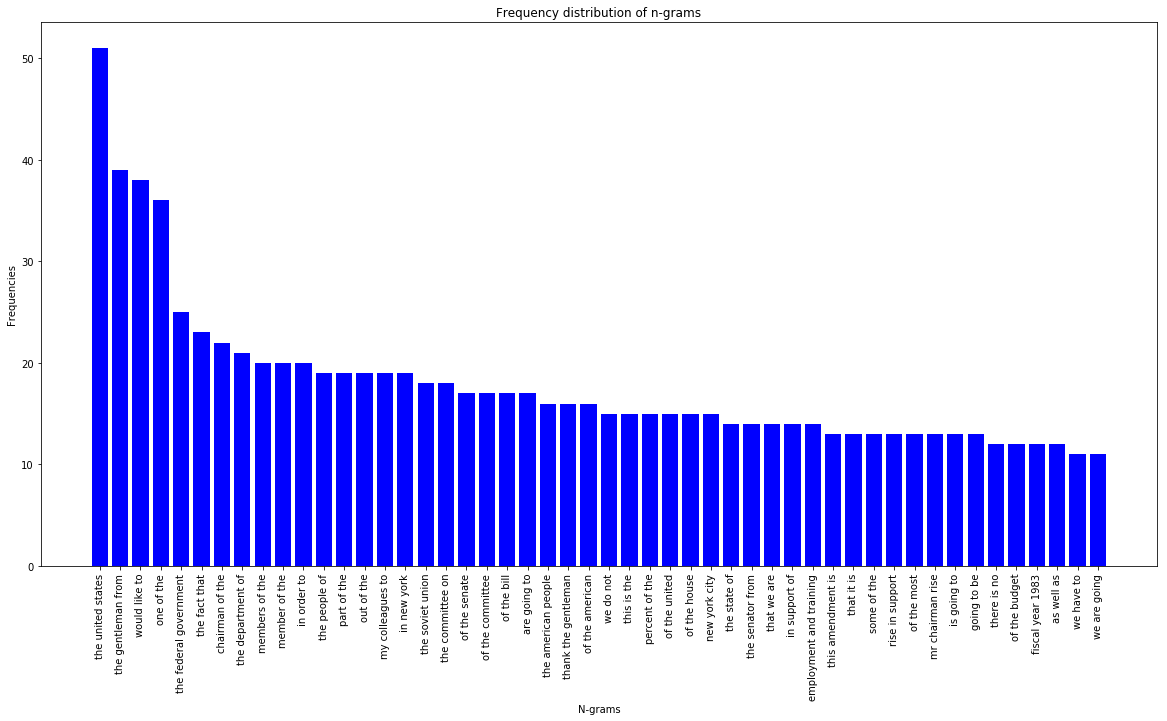

In [35]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(3,3))

In [76]:
reload(explore_data)
explore_data.ngrams_by_category(train, train_ids, descr, congress, 'Congress', p=0.3)

For Congress 97 top 10 (3, 3) ngrams are:
the united states
would like to
the american people
the gentleman from
one of the
the federal government
the committee on
the soviet union
the department of
the fact that


## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [37]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Output number of top/bottom scoring ngrams
TOP_N = 5

model_params = {
    'ngram_range': NGRAM_RANGE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
    'max_df': MAX_DOCUMENT_FREQUENCY,
    'top_k': TOP_K,
    'top_n': TOP_N
}

In [45]:
reload(preprocess_data)
train_vec, val_vec, test_vec = preprocess_data.ngram_vectorize(train, train_target, val, test, **model_params)

/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Total vocabulary size: 12082
Number of stop words 153920

Top 5 ngrams by differentiating score:
mr president 	 94.2
senator 	 60.6
president 	 48.8
senator from 	 38.7
the senator 	 36.9

Bottom 5 ngrams by differentiating score:
war and 	 0.0
shown that 	 0.0
say in 	 0.0
denying 	 0.0
70 percent 	 0.0


In [46]:
len(train), len(val), len(test)

(996, 332, 332)

In [47]:
train_vec.shape, val_vec.shape, test_vec.shape

((996, 12082), (332, 12082), (332, 12082))

### Saving processed files

In [41]:
pwd

'/tf/notebooks/final-project/Classification'

In [61]:
data_path = '/tf/notebooks/final-project/Classification/data'

In [68]:
scipy.sparse.save_npz(os.path.join(data_path, 'train_vec.npz'), train_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'val_vec.npz'), val_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'test_vec.npz'), test_vec)

In [69]:
train_vec = scipy.sparse.load_npz(os.path.join(data_path, 'train_vec.npz'))
val_vec = scipy.sparse.load_npz(os.path.join(data_path, 'val_vec.npz'))
test_vec = scipy.sparse.load_npz(os.path.join(data_path, 'test_vec.npz'))

In [70]:
train_vec.shape, val_vec.shape, test_vec.shape

((996, 12082), (332, 12082), (332, 12082))

In [72]:
with open(os.path.join(data_path, 'train_list'), 'wb') as fp:
    pickle.dump(train, fp)
with open(os.path.join(data_path, 'train_ids'), 'wb') as fp:
    pickle.dump(train_ids, fp)
with open(os.path.join(data_path, 'train_target'), 'wb') as fp:
    pickle.dump(train_target, fp)
with open(os.path.join(data_path, 'val_list'), 'wb') as fp:
    pickle.dump(val, fp)
with open(os.path.join(data_path, 'val_ids'), 'wb') as fp:
    pickle.dump(val_ids, fp)
with open(os.path.join(data_path, 'val_target'), 'wb') as fp:
    pickle.dump(val_target, fp)
with open(os.path.join(data_path, 'test_list'), 'wb') as fp:
    pickle.dump(test, fp)
with open(os.path.join(data_path, 'test_ids'), 'wb') as fp:
    pickle.dump(test_ids, fp)
with open(os.path.join(data_path, 'test_target'), 'wb') as fp:
    pickle.dump(test_target, fp)

In [73]:
sum(train_target), sum(val_target), sum(test_target)

(498, 166, 166)

In [74]:
with open(os.path.join(data_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(data_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(data_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)
with open(os.path.join(data_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(data_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(data_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)
with open(os.path.join(data_path, 'test_list'), 'rb') as fp:
    test = pickle.load(fp)
with open(os.path.join(data_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(data_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)

In [75]:
sum(train_target), sum(val_target), sum(test_target)

(498, 166, 166)

### Model: Multi-Layer Perceptron (Vanilla NN)

In [20]:
import tensorflow as tf

from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [33]:
logs_base_dir = "/tf/notebooks/final-project/logs"

In [37]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """
    Creates an instance of a multi-layer perceptron model.

    Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    Returns
        An MLP model instance.
    """
    op_units, op_activation = 1, 'sigmoid'
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    
    return model

In [99]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """
    Trains n-gram model on the given dataset.

    Arguments:
        data: tuples of vectorized training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    Returns:
        tuple with accuracy and loss on validation data for the last interation
    """
    # Get the data.
    (x_train, train_labels), (x_val, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = 2

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=2),
        tf.keras.callbacks.TensorBoard(log_dir=logs_base_dir, 
                                       histogram_freq=0, 
                                       write_graph=True, 
                                       write_images=True)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    train_pred_probs = model.predict(x_train)
    val_pred_probs = model.predict(x_val)

    return history, train_pred_probs, val_pred_probs
    
    
    # Save model.
#     model.save('C97_mlp_model.h5')

#         train_preds = model.predict_classes(x_train)
#     val_preds = model.predict_classes(x_val)
    
#     return history['val_acc'][-1], history['val_loss'][-1]

In [100]:
history, train_pred_probs, val_pred_probs = train_ngram_model(((train_vec, train_target), (val_vec, val_target)))

Train on 3244 samples, validate on 1080 samples
Epoch 1/1000
 - 1s - loss: 0.6752 - acc: 0.7124 - val_loss: 0.6599 - val_acc: 0.6713
Epoch 2/1000
 - 1s - loss: 0.5912 - acc: 0.8567 - val_loss: 0.6195 - val_acc: 0.6926
Epoch 3/1000
 - 1s - loss: 0.4952 - acc: 0.8844 - val_loss: 0.5868 - val_acc: 0.6944
Epoch 4/1000
 - 1s - loss: 0.4077 - acc: 0.9152 - val_loss: 0.5673 - val_acc: 0.7028
Epoch 5/1000
 - 1s - loss: 0.3299 - acc: 0.9365 - val_loss: 0.5557 - val_acc: 0.7130
Epoch 6/1000
 - 1s - loss: 0.2703 - acc: 0.9528 - val_loss: 0.5498 - val_acc: 0.7176
Epoch 7/1000
 - 1s - loss: 0.2191 - acc: 0.9686 - val_loss: 0.5491 - val_acc: 0.7120
Epoch 8/1000
 - 1s - loss: 0.1803 - acc: 0.9766 - val_loss: 0.5506 - val_acc: 0.7093
Epoch 9/1000
 - 1s - loss: 0.1506 - acc: 0.9827 - val_loss: 0.5548 - val_acc: 0.7139
Validation accuracy: 0.7138888835906982, loss: 0.5548078227926183


## Model evaluation

In [104]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

771

Confusion matrix, without normalization
[[366 174]
 [135 405]]


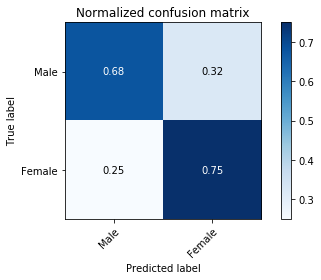

In [112]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

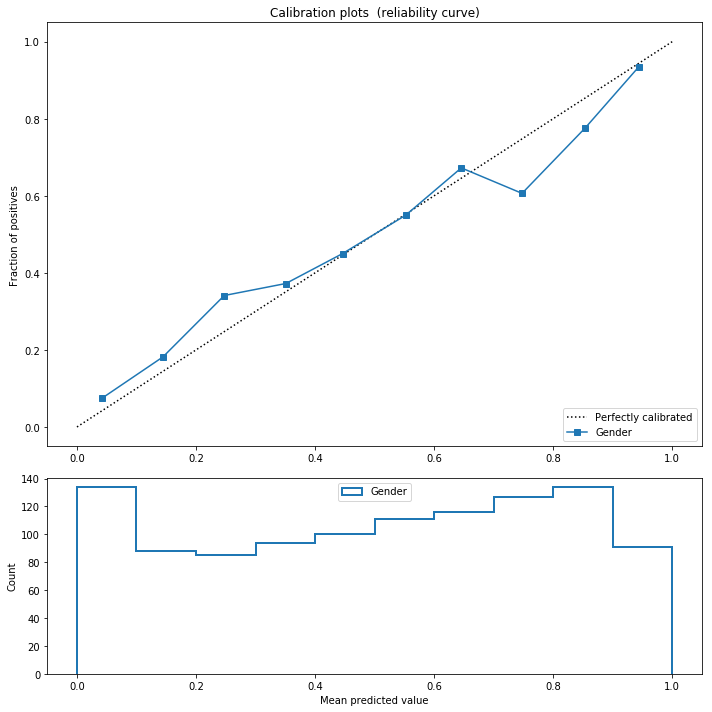

In [118]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [203]:
reload(explore_data)
explore_data.check_bin_probs_distr(val_target, val_pred_probs, val_ids, descr)

,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
1,0.45,0.70,1.04,0.88,0.58,0.96
2,1.00,0.85,0.99,0.97,1.15,0.90
3,1.47,1.32,0.97,1.11,1.29,1.07


In [216]:
reload(explore_data)
explore_data.ngrams_by_bin(val, val_pred_probs)


In 0.4 bin top 10 ngrams:

the senator from
the united states
would like to
the gentleman from
ask unanimous consent
of the bill
in the record
in order to
unanimous consent that
ask unanimous consent that
--------------------

In 0.6 bin top 10 ngrams:

the united states
the gentleman from
would like to
the soviet union
the department of
one of the
the federal government
of the united
of the united states
of the american
--------------------

In 1.0 bin top 10 ngrams:

the united states
would like to
the soviet union
the gentleman from
one of the
thank the gentleman
in support of
my colleagues to
the people of
the gentleman for
--------------------


In [242]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr)


True positive (Predicted prob: 0.95):

Ethnicity W
Age_lt_med 1.0
speaker Mrs. MARTIN of Illinois
char_count 1292
Party R
word_count 238
match exact
speakerid 97108370.0
Female 1.0
Congress 97
date 19821130
State IL
Full Name MARTIN, LYNN
NonWhite 0.0
Chamber H
Age 43.0

 I thank the gentleman for yielding. Mr. Speaker. I do not know why any of us should be surprised at the courage and the daring and. almost. occasionally fey part of PAUL FINDLEY. His hero is Abraham Lincoln. He is a Lincoln collector. His office is a repository. really. of Lincoln memorabilia. I think the spirit that moved the greatest son of Illinois is part of. what moved PAUL FINDLEY. I think he cared about peoples rights. If he saw that a right was being abrogated or abridged. even in an unpopular area. lie moved in. If It were equal rights in this Nation or rights in other nations. he moved in. He would represent the farmers. He does represent the farmers in his district. But if somebody was getting too much mon